# hetdex_get_spec: Extracting a sourcelist through the commandline 

This notebook demonstrates how to grab 1D aperture summed HETDEX spectra for an input of ID, RA and DEC using the `Extract` Class API from `HETDEX_API`. This can be done most directly using the command line tool `get_spec.py`. It can be used both interactively on a compute node via `idev` or through a jupyter notebook as shown here, as well as within a slurm job file. If you find you need to run as a slurm job, please ask Erin to set you up on wrangler. We will not be using stampede2 for slurm jobs.

Examples of what you might like to do with the spectra afterwards is shown later. For example the spectra produced from get_spec.py can be translated to line intensities, or approximate pass-band magnitudes with a few extra steps.

#### Import all necessary python packages. 
These are mainly for working within the notebook. The command line tool already has the necessary preamble built in.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle

from input_utils import setup_logging
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

import hetdex_api
from hetdex_api.extract import Extract
from hetdex_api.survey import Survey
from hetdex_api.shot import *

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


# IMPORTANT NOTE OF CAUTION WITH RUNNING ON TACC!!!

Because this script involves opening the Fibers class object which contains all fiber spectra from a 3 dither observation, you will be pulling in a lot of memory for each shot that is open. **NEVER** run this script from a login node on TACC. A login node is a node you access when you ssh in. 

You need to request a compute node instead by either 

(1) using the idev command :

`idev -p skx-dev `

if it works on a small catalog, you can always run interactively using a longer queue option

`idev -p skx-normal` 

(2) using a jupyter notebook 

(3) or by submitting the job into the slurm job scheduler (generally if you are working on more than ~200 shots

## Getting all spectra at a specified RA/DEC. This will search through all shots in HDR1

If a shotid is not specified the program will search for any shot within HDR1 that overlaps within an 11 arcmin radius of the input coordinates. Because of the non-contiguous VIRUS footprint, there is no guarantee the aperture defined by the input ra/dec/rad will contain enough fibers to do a measurement. The aperture radius is 3" by default or can be specified with the --rad argument. Use the --outfile argument to label the output pickle file. Otherwise the default 'output.pkl' will be used.

You can run these commands from the command line by removing the "!" command but be sure you are on a compute node by calling `idev` first.

In [3]:
!hetdex_get_spec --ra 150.02548 --dec 2.087987 --ID cosmos_LAE --outfile cosmos_LAE

[INFO - 2020-01-09 13:51:51,094] Extracting for ID: cosmos_LAE
[INFO - 2020-01-09 13:51:51,112] Searching through all shots
[INFO - 2020-01-09 13:51:51,112] Finding shots of interest
[INFO - 2020-01-09 13:51:52,767] Number of shots of interest: 18
[INFO - 2020-01-09 13:51:52,767] Extracting 18 sources
[INFO - 2020-01-09 13:51:52,771] Working on shot: 20170105009
[INFO - 2020-01-09 13:51:52,773] Accessing object one by one
[INFO - 2020-01-09 13:51:59,855] Working on shot: 20170106001
[INFO - 2020-01-09 13:51:59,856] Accessing object one by one
[INFO - 2020-01-09 13:52:05,849] Working on shot: 20170106002
[INFO - 2020-01-09 13:52:05,850] Accessing object one by one
[INFO - 2020-01-09 13:52:10,732] Working on shot: 20170106003
[INFO - 2020-01-09 13:52:10,733] Accessing object one by one
[INFO - 2020-01-09 13:52:16,206] Working on shot: 20170107012
[INFO - 2020-01-09 13:52:16,208] Accessing object one by one
[INFO - 2020-01-09 13:52:21,069] Working on shot: 20170107013
[INFO - 2020-01-09 1

## Speed things up using multiprocessing

You can speed up processes (by up to ~30x) with python multiprocessing if you are working interactively in a notebook or in an idev session (**NEVER FROM A LOGIN NODE**). Use the multiprocessing option with the argument -mp True or --multiprocess True 

In [4]:
!hetdex_get_spec --multiprocess -ra 150.02548 -dec 2.087987 -id mptest -o mptest

[INFO - 2020-01-09 13:55:06,201] Extracting for ID: mptest
[INFO - 2020-01-09 13:55:06,219] Searching through all shots
[INFO - 2020-01-09 13:55:06,219] Finding shots of interest
[INFO - 2020-01-09 13:55:08,011] Number of shots of interest: 18
[INFO - 2020-01-09 13:55:08,011] Extracting 18 sources
[INFO - 2020-01-09 13:55:08,054] Working on shot: 20170105009
[INFO - 2020-01-09 13:55:08,056] Working on shot: 20170106002
[INFO - 2020-01-09 13:55:08,057] Working on shot: 20170106001
[INFO - 2020-01-09 13:55:08,057] Working on shot: 20170106003
[INFO - 2020-01-09 13:55:08,058] Accessing object one by one
[INFO - 2020-01-09 13:55:08,058] Accessing object one by one
[INFO - 2020-01-09 13:55:08,059] Accessing object one by one
[INFO - 2020-01-09 13:55:08,059] Accessing object one by one
[INFO - 2020-01-09 13:55:08,061] Working on shot: 20170107012
[INFO - 2020-01-09 13:55:08,063] Working on shot: 20170107013
[INFO - 2020-01-09 13:55:08,063] Accessing object one by one
[INFO - 2020-01-09 13:55

## Save output as individual astropy tables for each ID/shot combination:

If you prefer to save each spectra to a table, you can do this. We don't recommend this for large numbers of data, but understand that sometimes its easy to start with a readable table. The tables will be stored in the files named `spec_[ID]_[shotid].tab`

In [5]:
!hetdex_get_spec  --multiprocess --single -ra 150.02548 -dec 2.087987 -id cosmos_lae

[INFO - 2020-01-09 13:55:11,030] Extracting for ID: cosmos_lae
[INFO - 2020-01-09 13:55:11,048] Searching through all shots
[INFO - 2020-01-09 13:55:11,048] Finding shots of interest
[INFO - 2020-01-09 13:55:12,614] Number of shots of interest: 18
[INFO - 2020-01-09 13:55:12,614] Extracting 18 sources
[INFO - 2020-01-09 13:55:12,654] Working on shot: 20170105009
[INFO - 2020-01-09 13:55:12,655] Working on shot: 20170106002
[INFO - 2020-01-09 13:55:12,657] Working on shot: 20170106001
[INFO - 2020-01-09 13:55:12,659] Working on shot: 20170107012
[INFO - 2020-01-09 13:55:12,660] Accessing object one by one
[INFO - 2020-01-09 13:55:12,660] Accessing object one by one
[INFO - 2020-01-09 13:55:12,660] Working on shot: 20170106003
[INFO - 2020-01-09 13:55:12,661] Accessing object one by one
[INFO - 2020-01-09 13:55:12,661] Accessing object one by one
[INFO - 2020-01-09 13:55:12,662] Accessing object one by one
[INFO - 2020-01-09 13:55:12,664] Working on shot: 20171220015
[INFO - 2020-01-09 1

## Getting all spectra at a specified RA/DEC in a specific OBSERVATION/SHOT

Perhaps you only want to focus on a specific shot. Then you can use the -s argument to put the shotid either as an interger value 'YYYYMMDDOBS'= 20190104008 or as a str '20190104v009'. Note if you don't give an --ID option the default is 'DEX'

This is a command line routine so remove the "!" if you are running in a terminal.

In [6]:
!hetdex_get_spec  -ra 8.86535 -dec 0.59352  -s 20190104008 -o 20190104008

[INFO - 2020-01-09 13:55:15,618] Extracting for ID: 1
[INFO - 2020-01-09 13:55:15,636] Finding shots of interest
[INFO - 2020-01-09 13:55:15,637] Number of shots of interest: 1
[INFO - 2020-01-09 13:55:15,637] Extracting 1 sources
[INFO - 2020-01-09 13:55:15,638] Working on shot: 20190104008
[INFO - 2020-01-09 13:55:15,639] Accessing object one by one
[INFO - 2020-01-09 13:55:46,506] Extracting 1


This is particularly helpful if you plan to submit each shot as a separate task. For this reason, I suggest changing the default --outfile option to -o 20190104008 to create the output pickle file 20190104008

## Work on a list of ID/RA/DECs

This can either be a saved astropy table, or an space delimited text file with 3 columns where the columns are ID, RA, DEC. If you want more functionality with your input catalog, just talk to Erin. Note that running this job will take about 30 minutes so only execute if you want to wait around to explore the output.

In [7]:
!cp /work/05350/ecooper/stampede2/3dhst/3dhst_input.cat .

In [ ]:
!hetdex_get_spec  --multiprocess -i '3dhst_input.cat' -o '3dhst'

## Example Batch Job production - wrangler

To help those with lists that need to access more than ~200 shots here is an example of how you can break down extractions into several slurm tasks giving each shot a separate process. First use the `get_shots_of_interest.py` function (on a login node is fine) to retrieve a text list of SHOTIDs stored in the file `shotlist` in the working directory. 

You can see my example of this run in the directory:

    /work/05350/ecooper/wrangler/test_extract/3dhst


Feel free to try it yourself on **wrangler**

In [ ]:
! mkdir 3dhst
! cd 3dhst
! cp /work/05350/ecooper/wrangler/test_extract/3dhst/3dhst_input.cat .

In [ ]:
! hetdex_get_shots -i '3dhst_input.cat'

Then you can use `awk` to create a process/task list of all the jobs you want to do. It is most efficient to send each shot in as a separate process.

In [ ]:
! awk '{print "hetdex_get_spec -i 3dhst_input.cat -s", $1, "-o", $1}' shotlist > run_shot

Then you need to combine all the files together to make for easier analysis. Use the --fits option to generate a astropy fits table as output. It will default to a pickle file.

In [ ]:
! hetdex_get_spec --fits --merge --outfile '3dhst_master'

# Reading in the output - astropy FITS files

By default the output data is stored as a FITS file using astropy Table fuction. You can read in the output file produced using astropy Tables. The show_in_notebook() feature is handy for interactive searching of your output.

In [9]:
from astropy.table import Table
source_table = Table.read('/work/05350/ecooper/stampede2/3dhst/3dhst.fits')

In [10]:
source_table.show_in_notebook()

idx,ID,shotid,wavelength [1036],spec [1036],spec_err [1036],weights [1036]
,,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),
0,19574,20170129003,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.9407037629016222 .. 0.965458090523065
1,19574,20170131038,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.013338411541438926 .. 0.03906007072383373
2,19574,20170202006,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.8738681359285264 .. 0.8879360545217284
3,19574,20170202007,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.9458347653492903 .. 0.9459554869937444
4,19574,20170301015,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.0012471488510860372 .. 0.006057326473538754
5,19574,20170301006,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.9453869355309662 .. 0.9435111854390659
6,19574,20170306021,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.949853246341783 .. 0.9297050849009797
7,19574,20170301016,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.0015285546355541446 .. 0.007658838309313297
8,19574,20170306018,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.012098856203506916 .. 0.03839687722628225


In [11]:
source_table[49]

ID,shotid,wavelength [1036],spec [1036],spec_err [1036],weights [1036]
,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),
int64,int64,float64,float64,float64,float64
22372,20170202006,3470.0 .. 5540.0,nan .. nan,nan .. nan,0.9414811124967308 .. 0.9481296342243881


The spectrum can be accessed by row index:

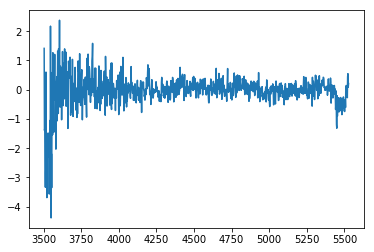

In [12]:
wave = source_table['wavelength'][49]
spec = source_table['spec'][49]
plt.plot(wave, spec)